## 初期設定

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 画像の読み込み

In [3]:
img = cv2.cvtColor(cv2.imread('./img/colorful.png'), cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## ハフ変換による円の抽出

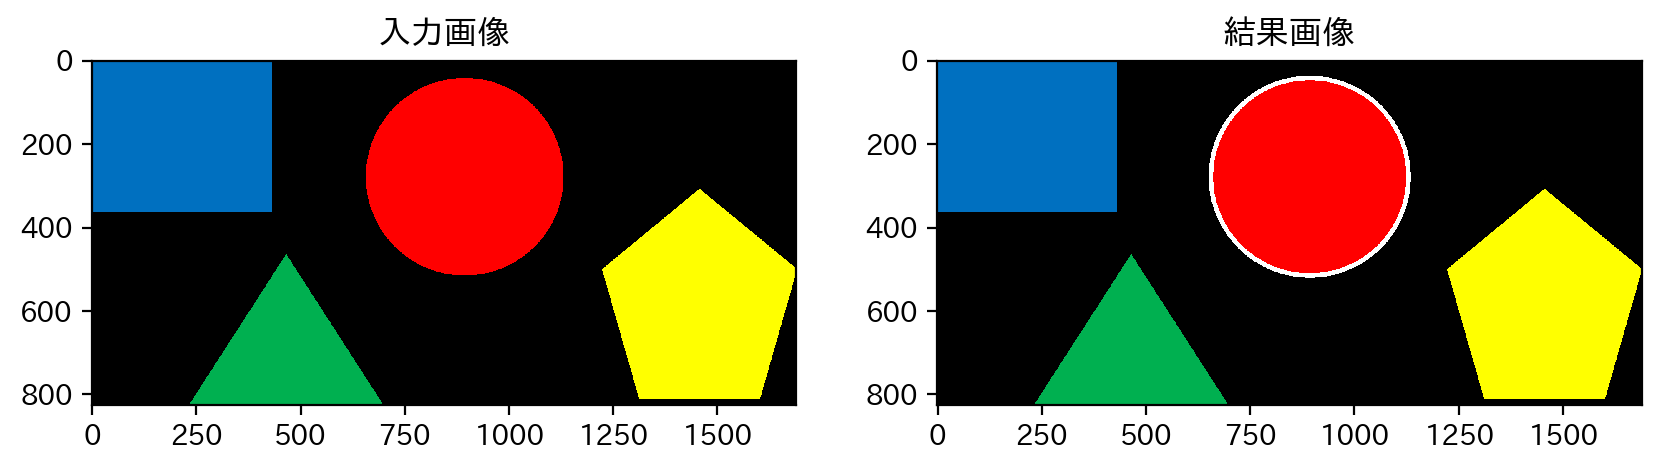

In [8]:
circles = cv2.HoughCircles(gray_img,cv2.HOUGH_GRADIENT,2,50,param1=60,param2=90,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
dst_img = img.copy()
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(dst_img,(i[0],i[1]),i[2],(255,255,255),10)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('入力画像')
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('結果画像')
ax2.imshow(dst_img)
plt.show()

## ラベリング処理による抽出領域のラベリング

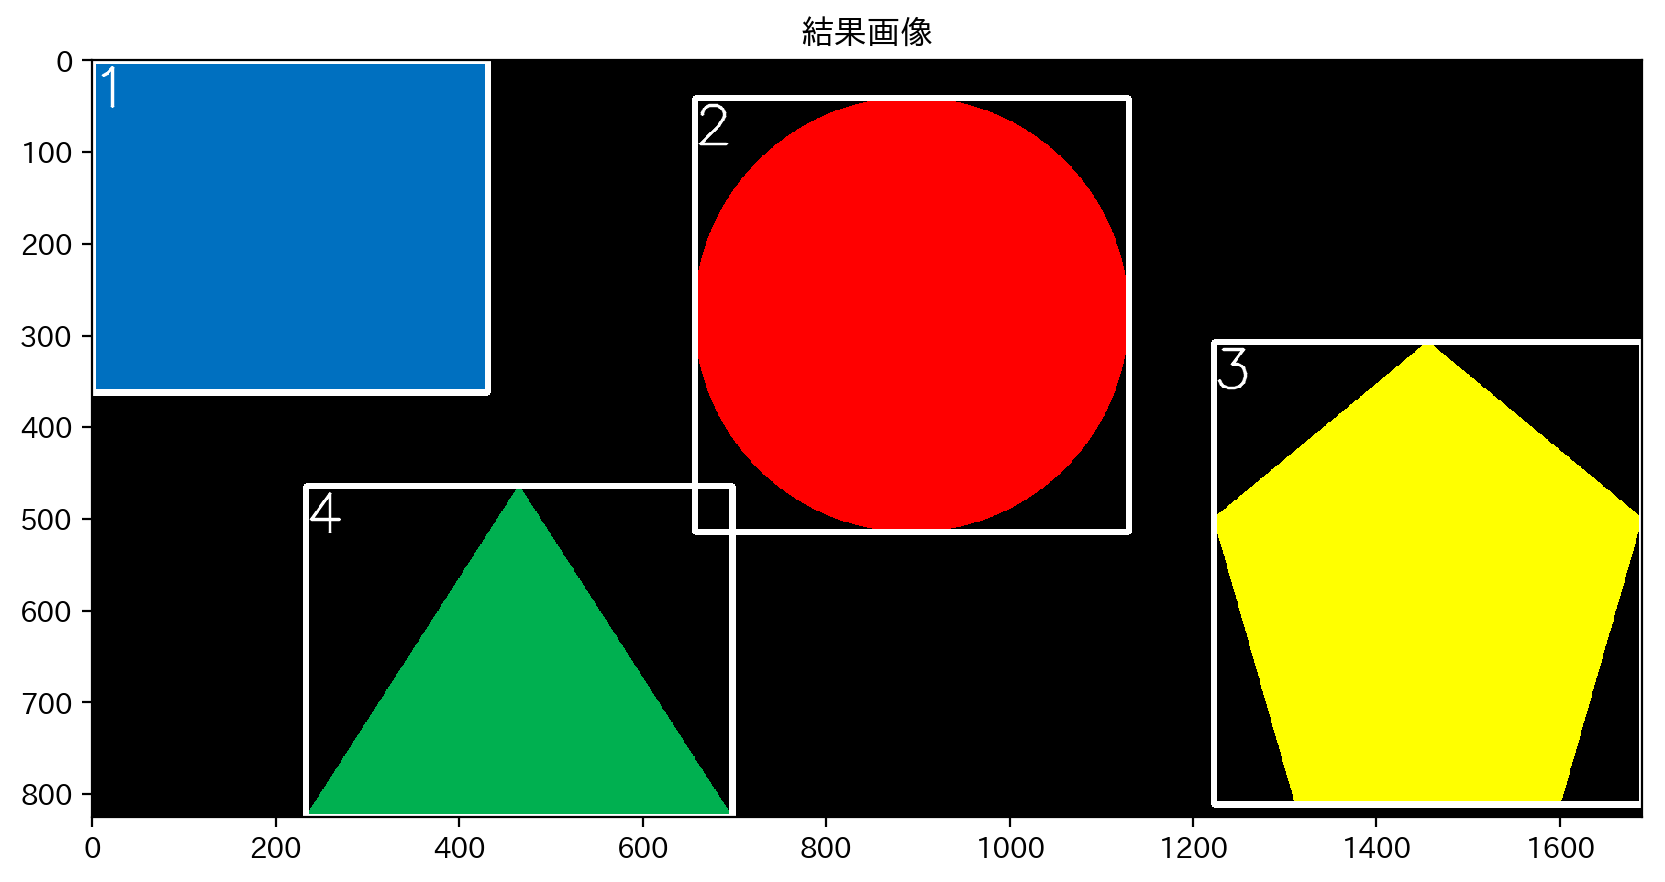

In [4]:
label_num, label_img, contours, GoCs = cv2.connectedComponentsWithStats(gray_img)
dst_img = img.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
for label in range(1, label_num):
    x, y, w ,h, size = contours[label]
    cv2.putText(dst_img,str(label),(x, y+50), font, 2,(255,255,255),2,cv2.LINE_AA)
    dst_img = cv2.rectangle(dst_img, (x,y), (x+w,y+h), (255,255,255), 5) 
    
fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('結果画像')
ax1.imshow(dst_img)
plt.show()

## テンプレートマッチング

### テンプレート画像の読み込みと表示

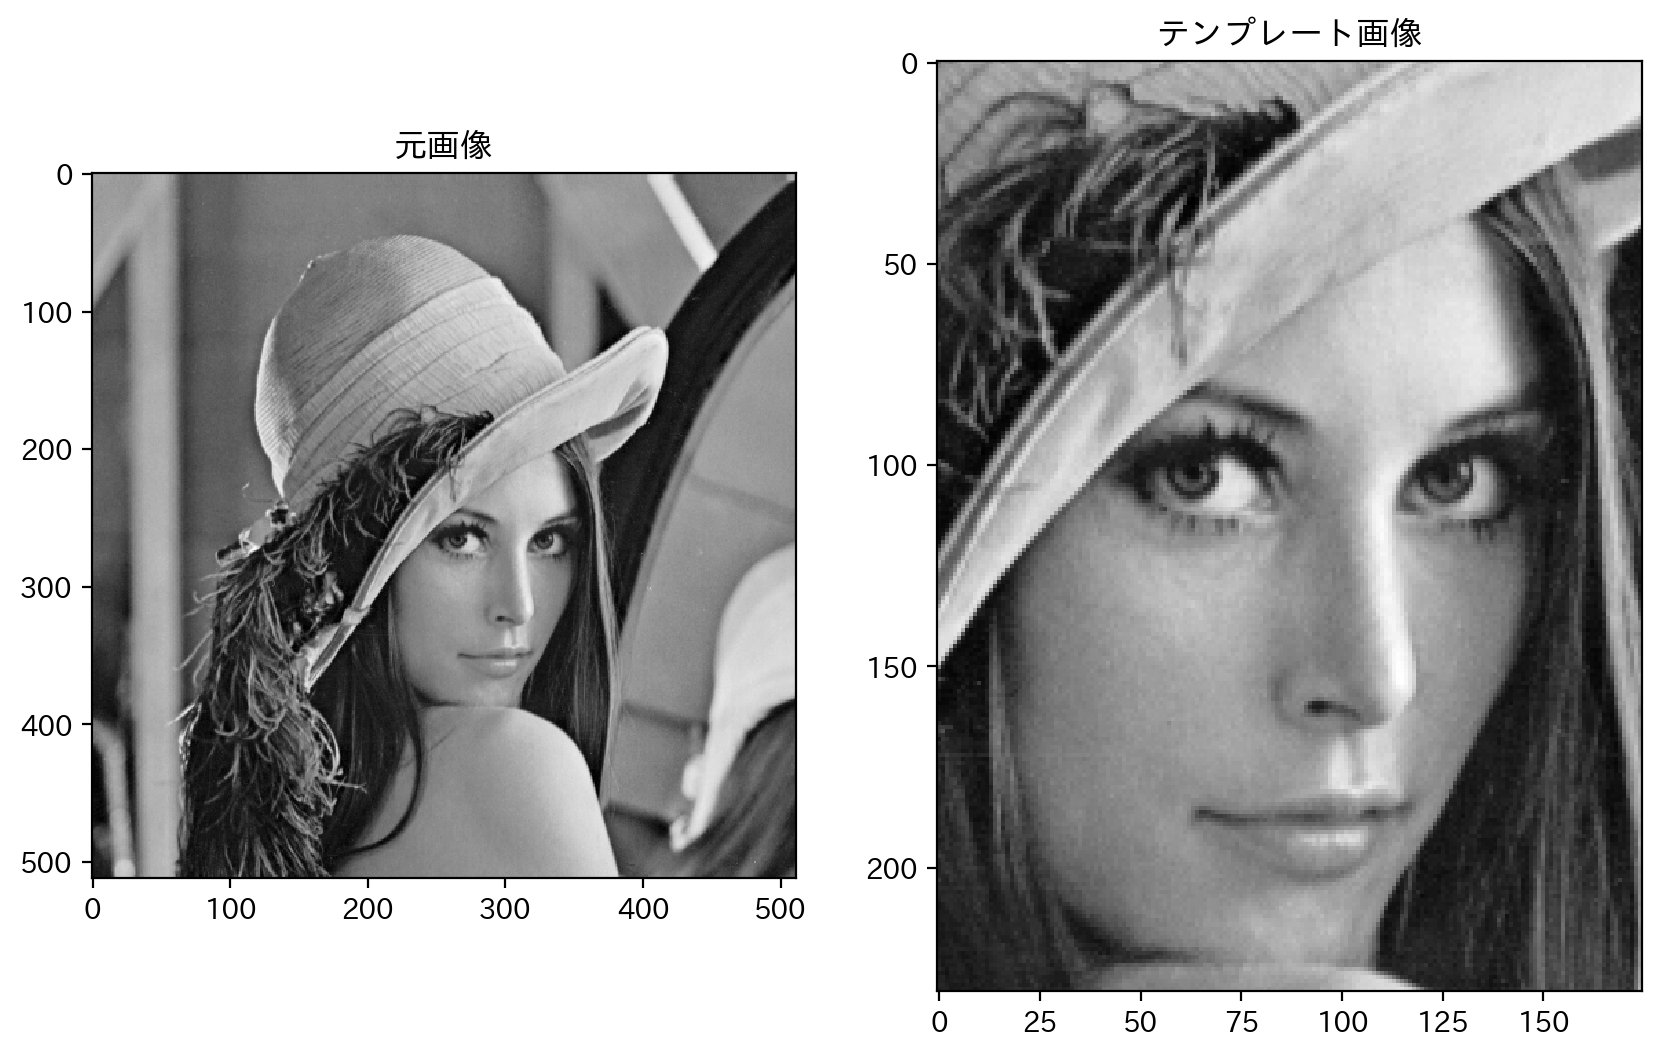

In [5]:
template_img = cv2.imread('./img/template.png', 0)
sample_img = cv2.imread('./img/lenna.png', 0)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('元画像')
ax1.imshow(sample_img, cmap='gray')

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('テンプレート画像')
ax2.imshow(template_img, cmap='gray')
plt.show()

### テンプレートマッチング

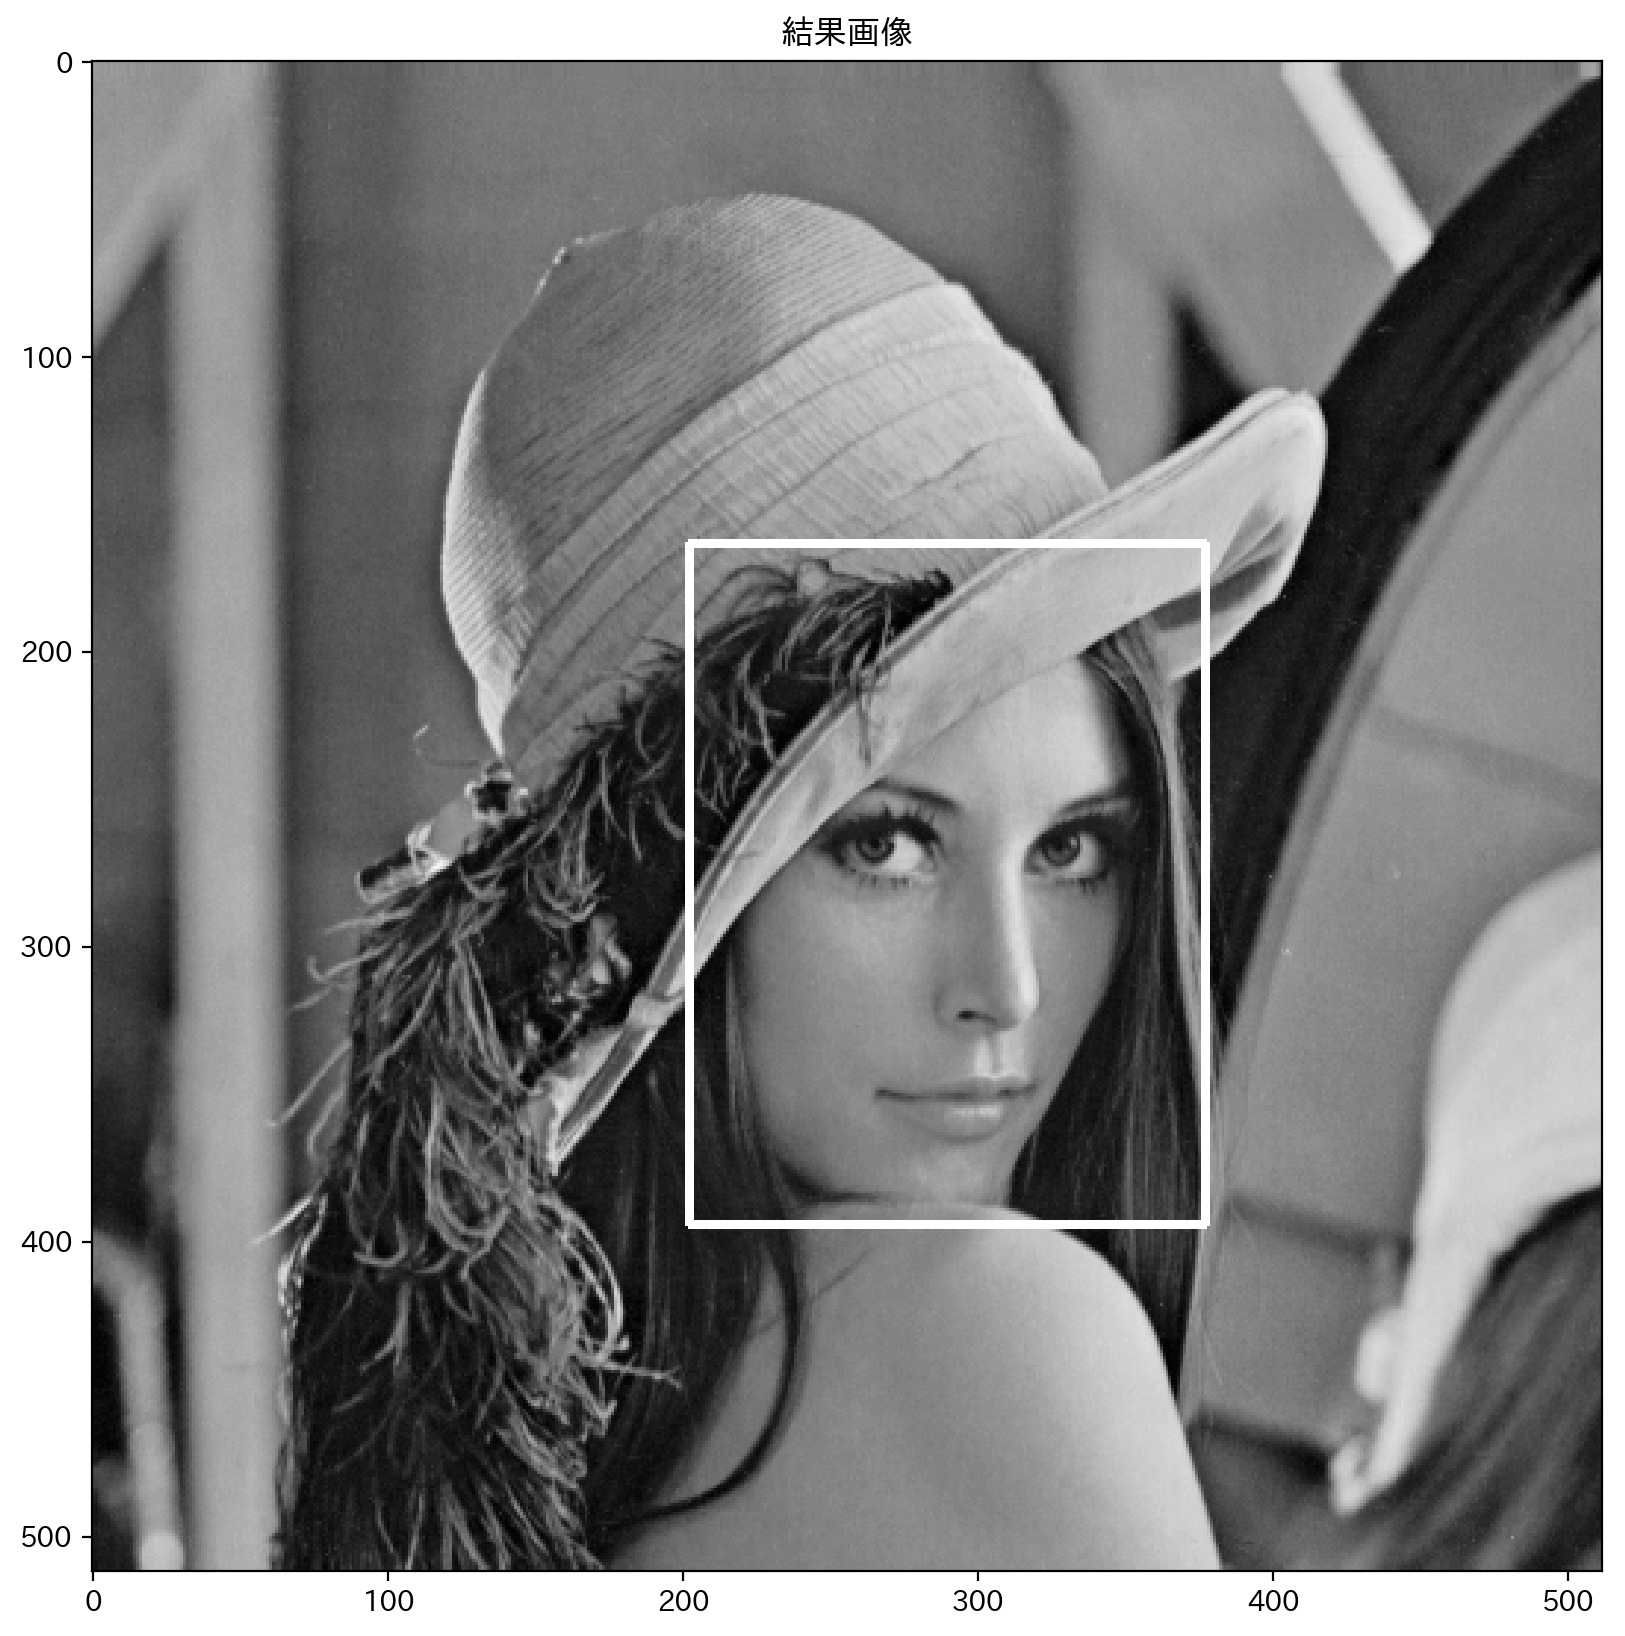

In [6]:
w, h = template_img.shape
src_img = sample_img.copy()
# テンプレートマッチング
result = cv2.matchTemplate(src_img, template_img, cv2.TM_SQDIFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

top_left = min_loc
bottom_right = (top_left[0] + h, top_left[1] + w)
cv2.rectangle(src_img, top_left, bottom_right, 255, 2)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('結果画像')
ax1.imshow(src_img, cmap='gray')
plt.show()

## SIFT特徴量

### テンプレート画像から特徴量を算出

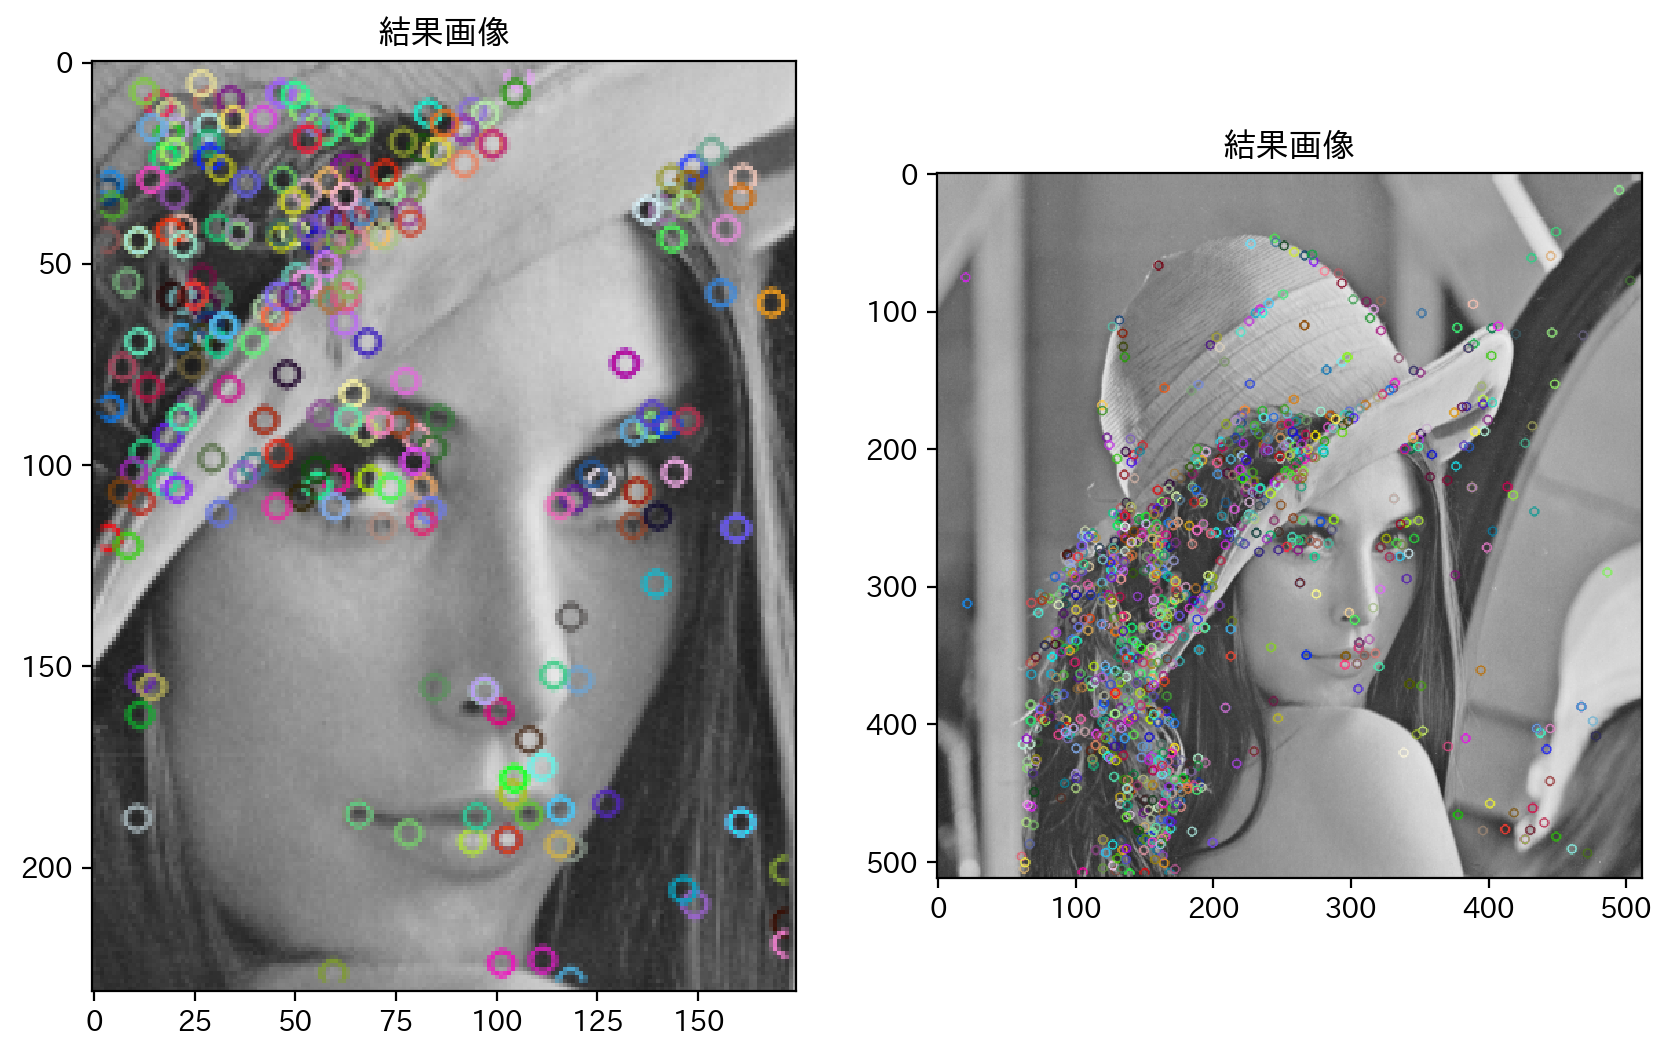

In [7]:
img1 = template_img.copy()
img2 = sample_img.copy()

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(template_img, None)
kp2, des2 = sift.detectAndCompute(img2, None)

dst1 = cv2.drawKeypoints(img1, kp1, des1)
dst2 = cv2.drawKeypoints(img2, kp2, des2)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('結果画像')
ax1.imshow(dst1, cmap='gray')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('結果画像')
ax2.imshow(dst2, cmap='gray')
plt.show()

### 特徴量マッチング

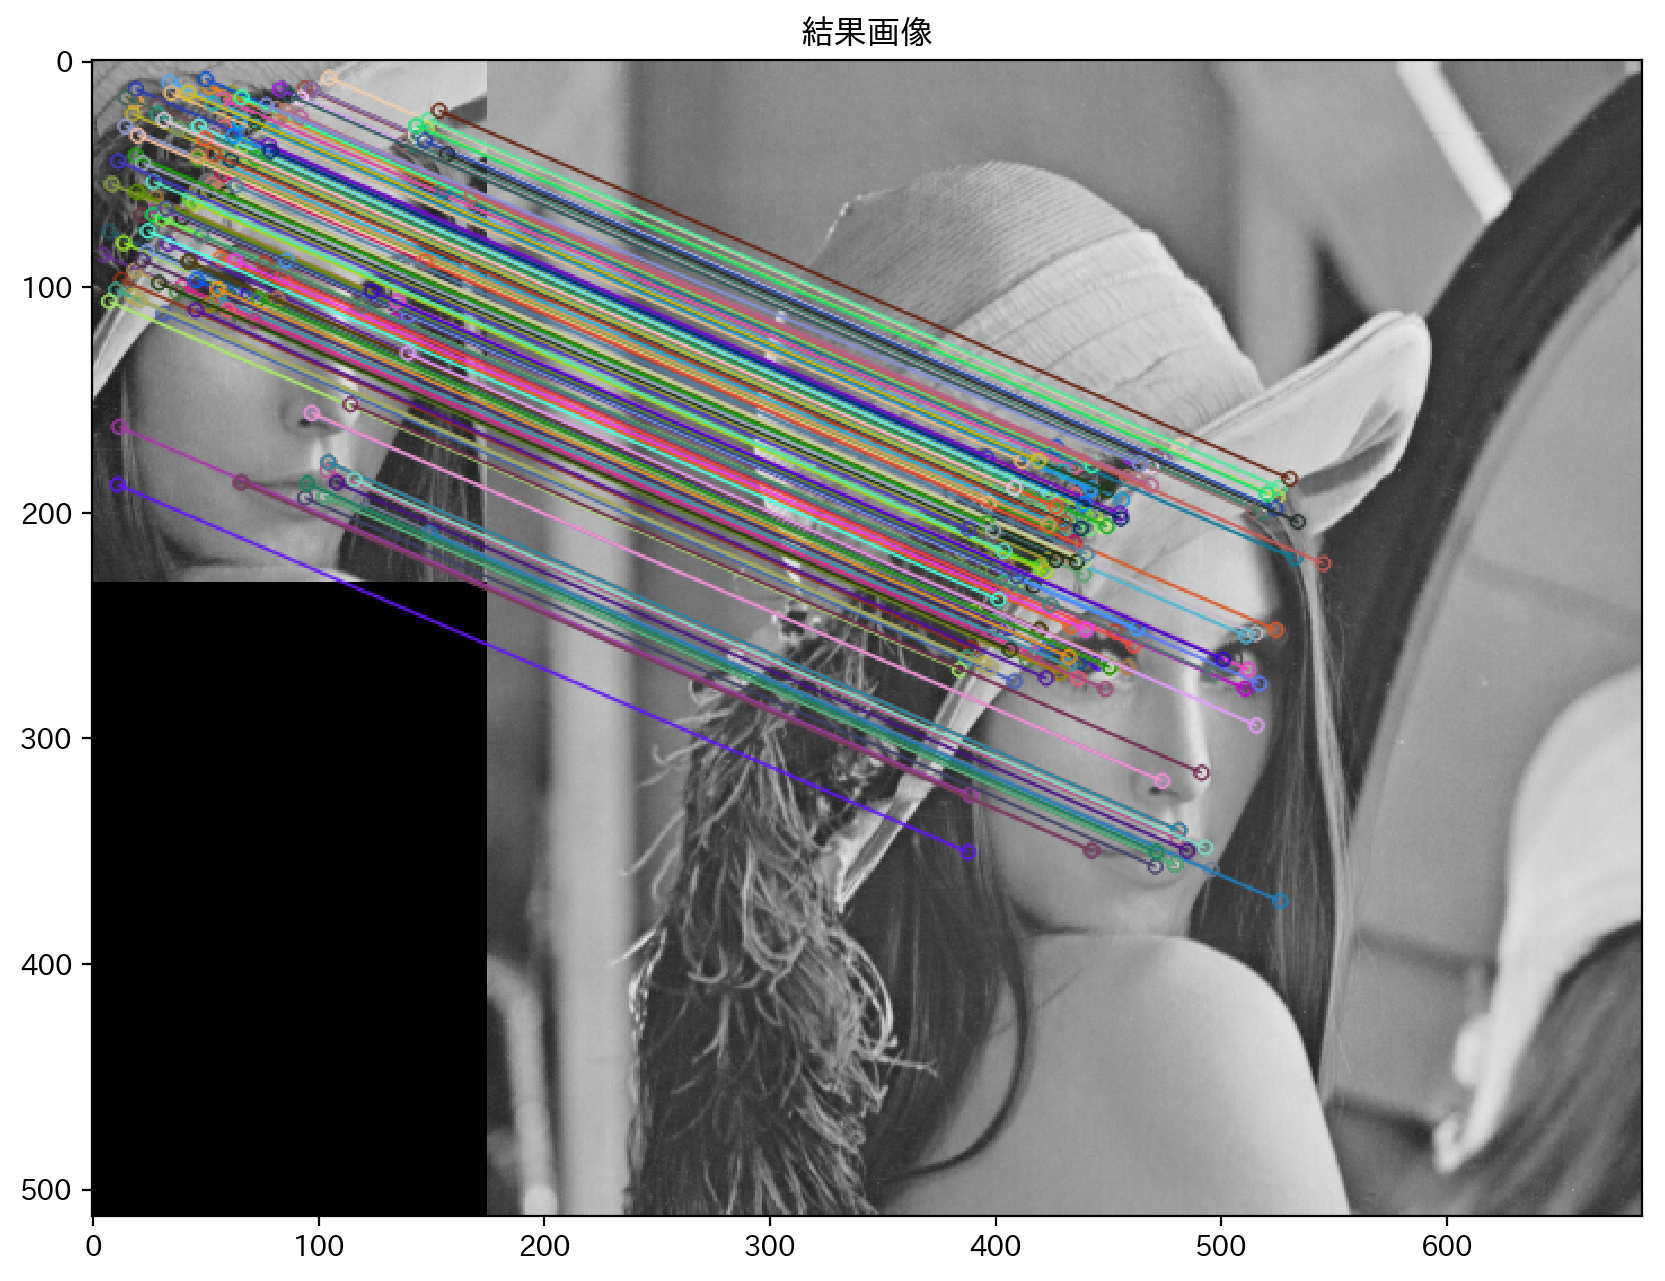

In [8]:
bf_matcher = cv2.BFMatcher()
matches = bf_matcher.knnMatch(des1, des2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None, flags=2)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('結果画像')
ax1.imshow(img3, cmap='gray')
plt.show()

### 検出領域の描画

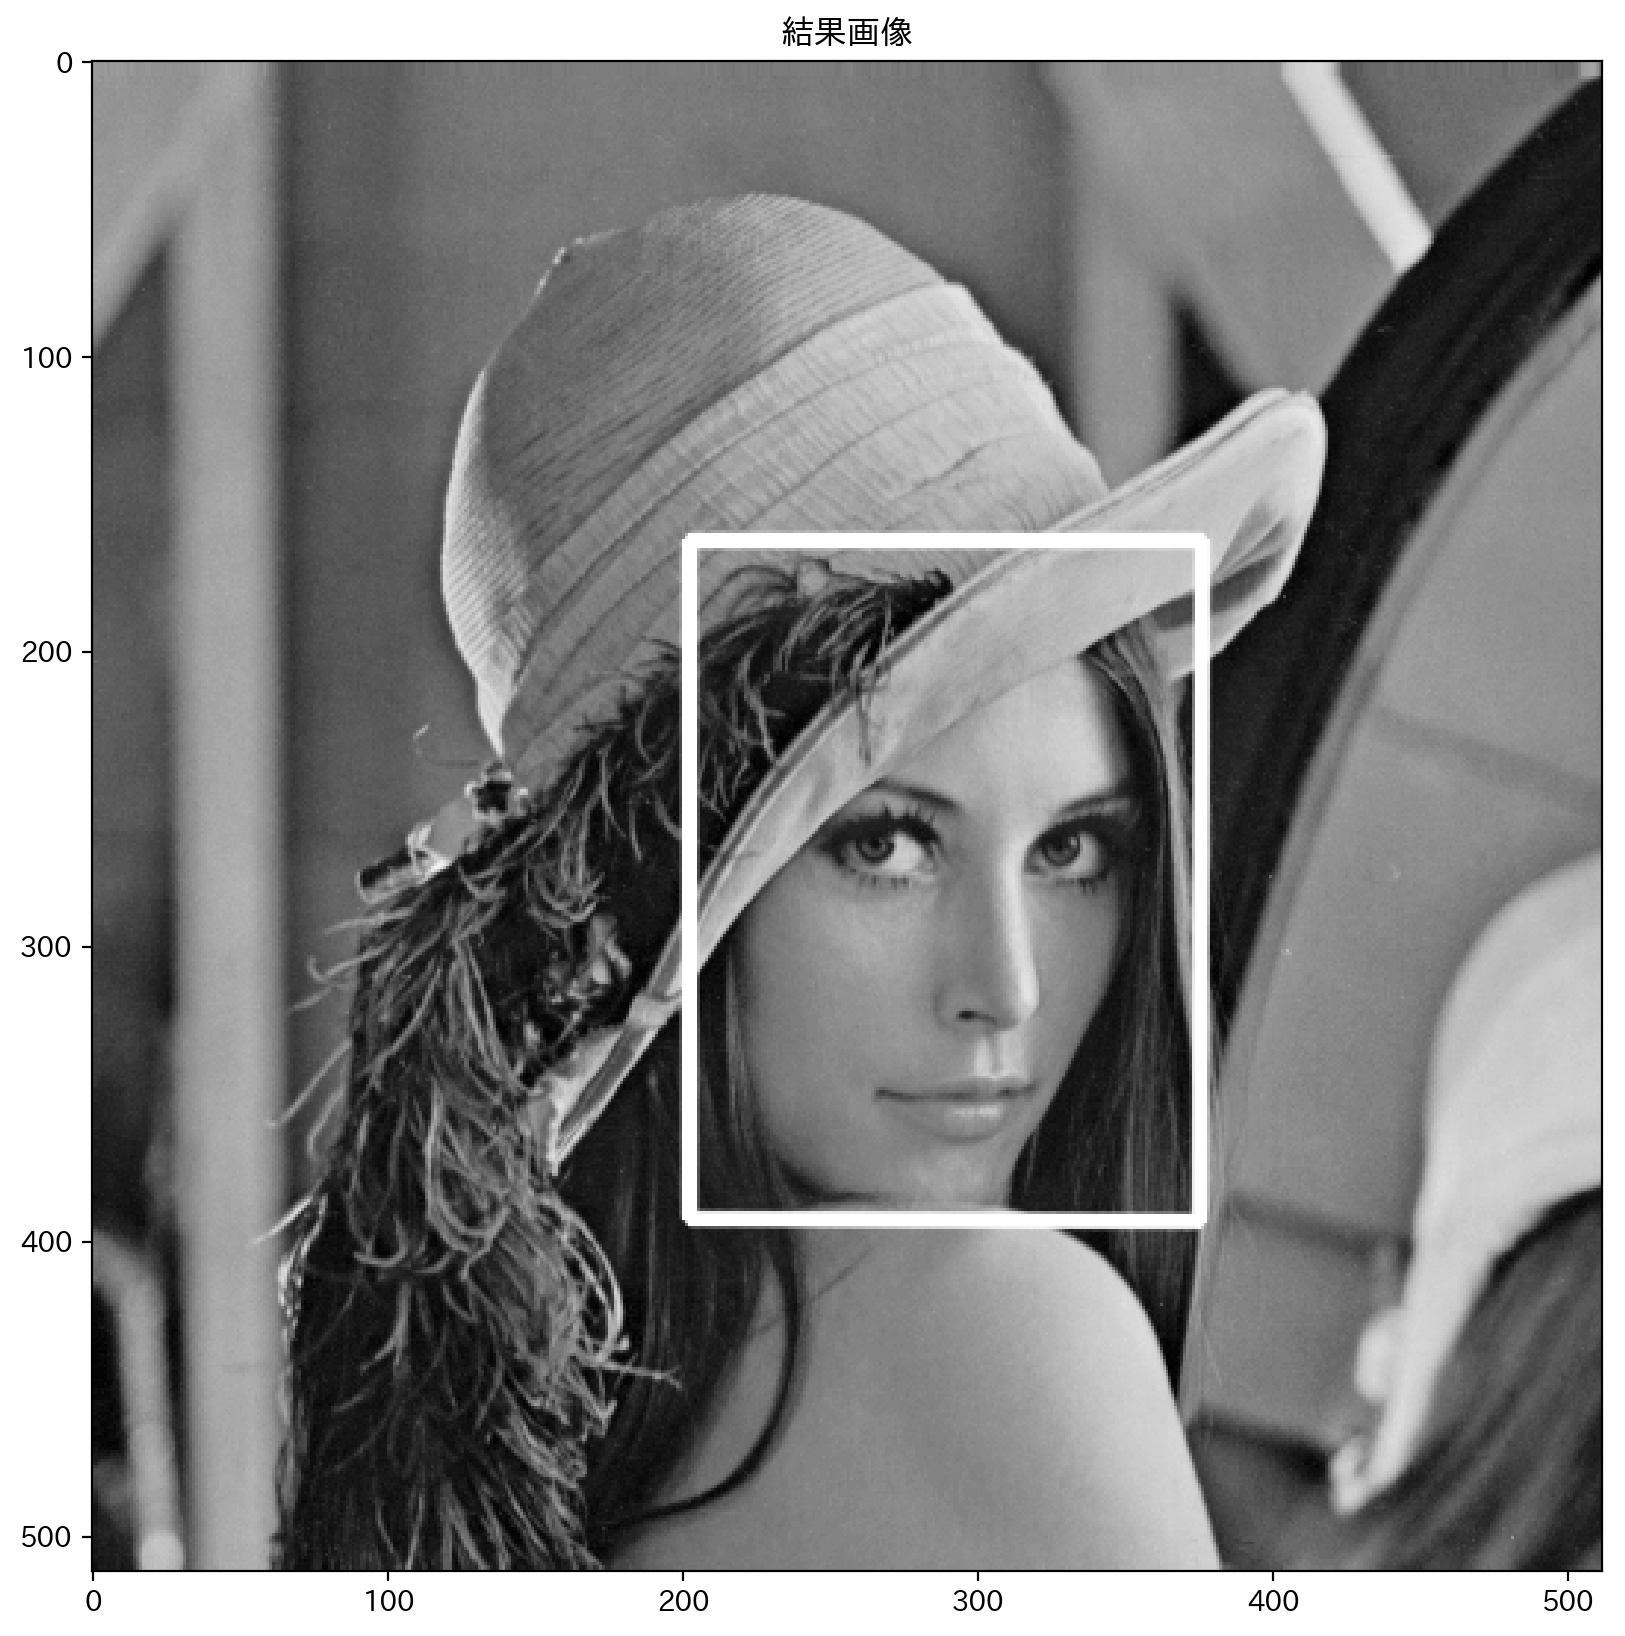

In [9]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

img4 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('結果画像')
ax1.imshow(img4, cmap='gray')
plt.show()

## テンプレートマッチング vs SIFT 特徴量

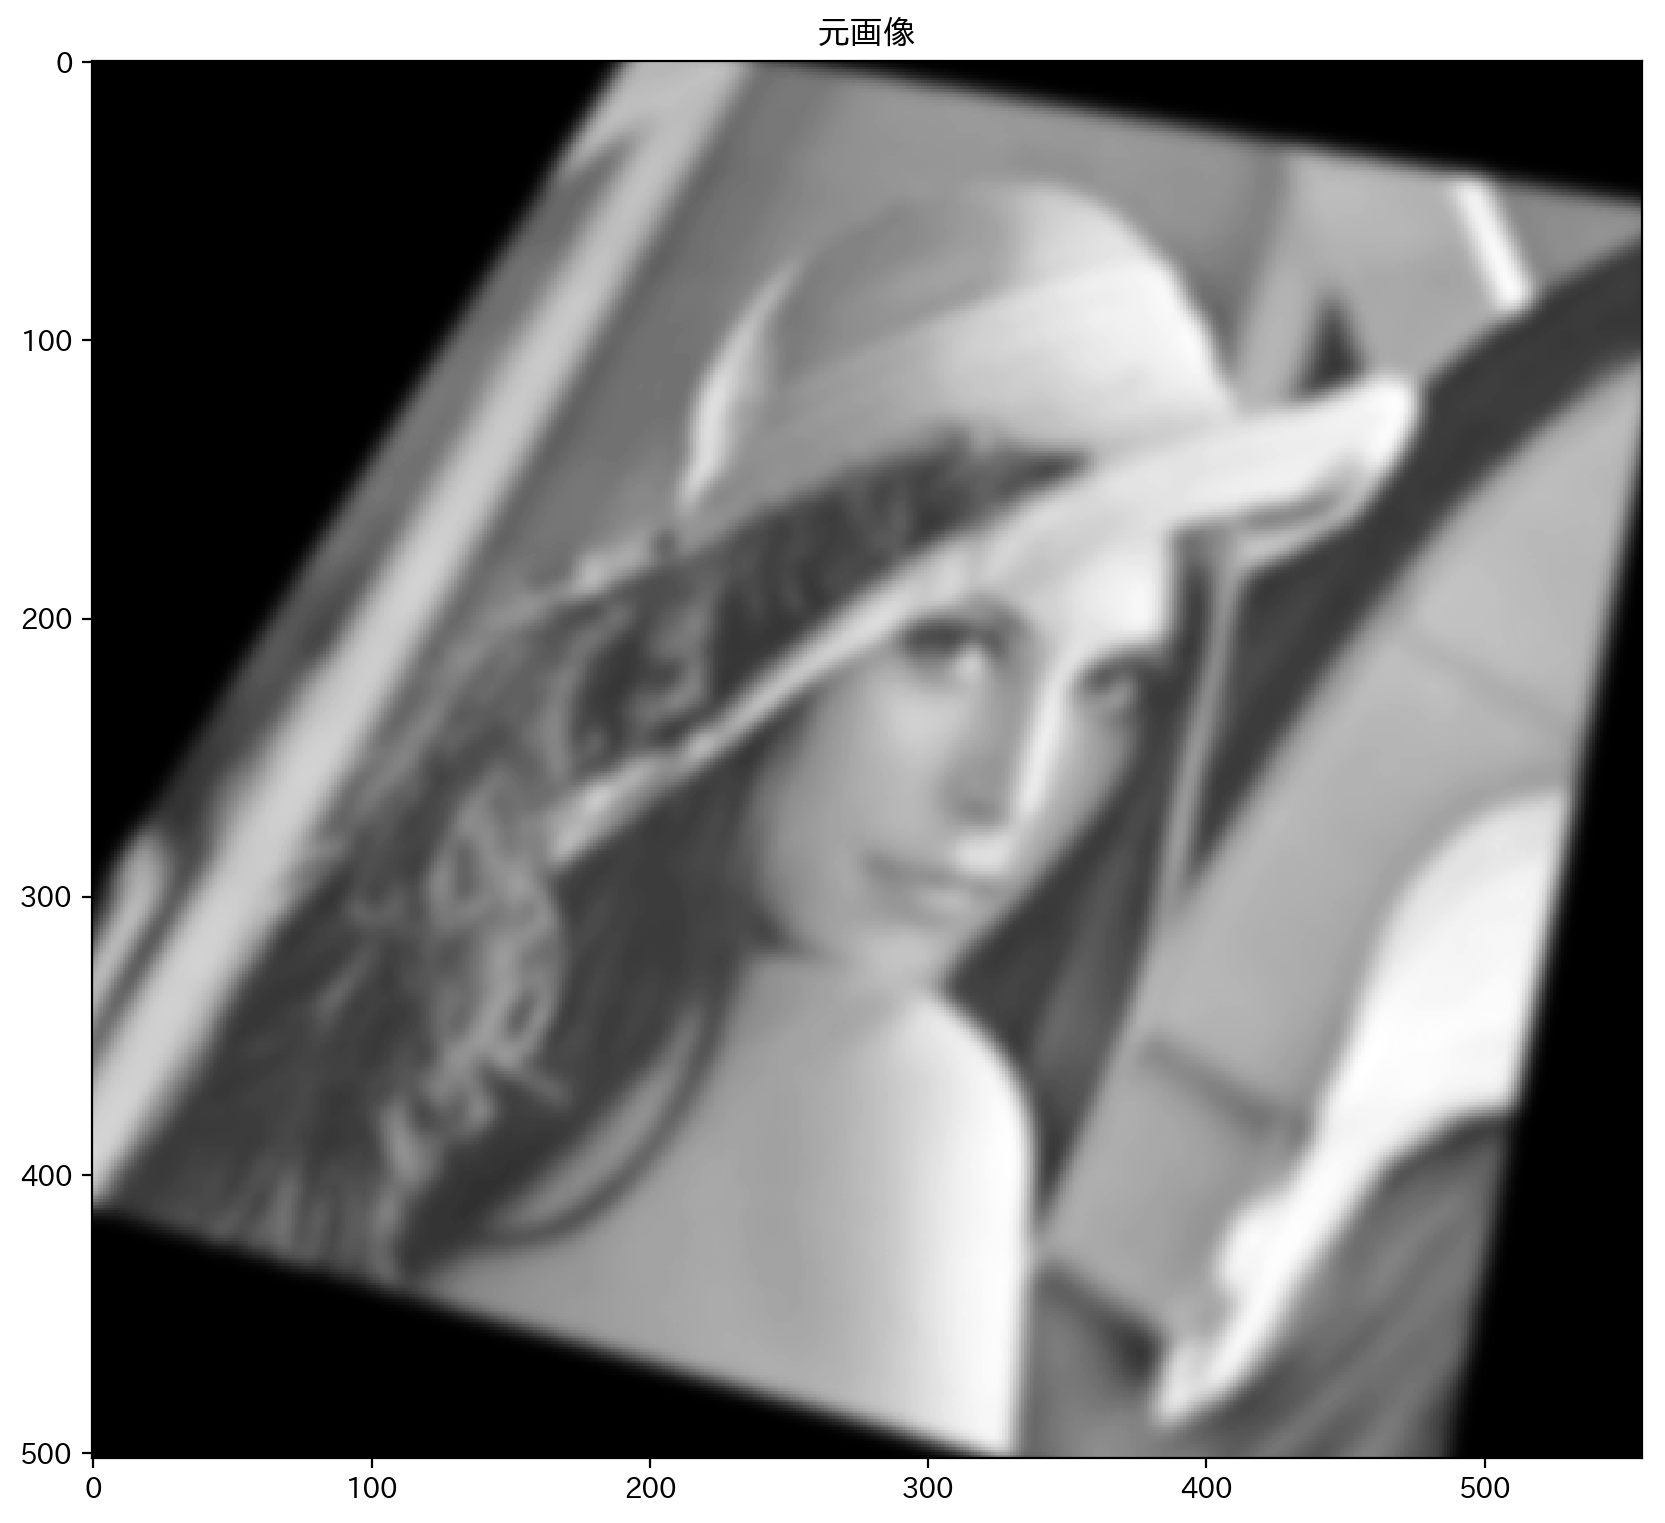

In [10]:
img5 = cv2.imread('./img/lenna3.png', 0)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('元画像')
ax1.imshow(img5, cmap='gray')
plt.show()

### テンプレートマッチング

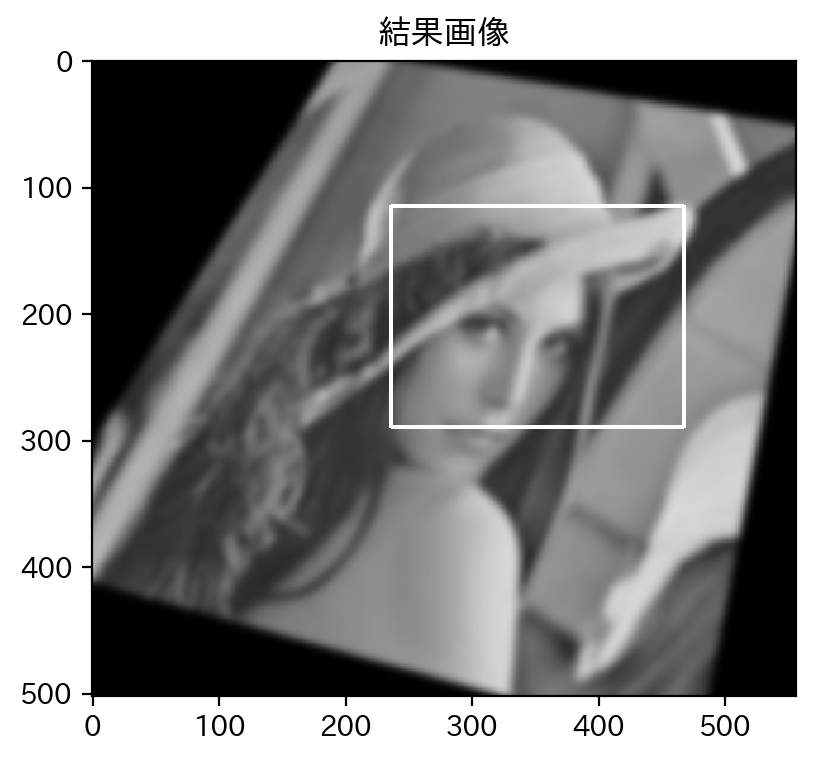

In [11]:
src_img2 = img5.copy()
result2 = cv2.matchTemplate(src_img2, template_img, cv2.TM_SQDIFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result2)
top_left = min_loc
bottom_right = (top_left[0] + h, top_left[1] + w)
src_img2 = cv2.rectangle(src_img2, top_left, bottom_right, 255, 2)
fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('結果画像')
ax1.imshow(src_img2, cmap='gray')
plt.show()

## SIFTマッチング

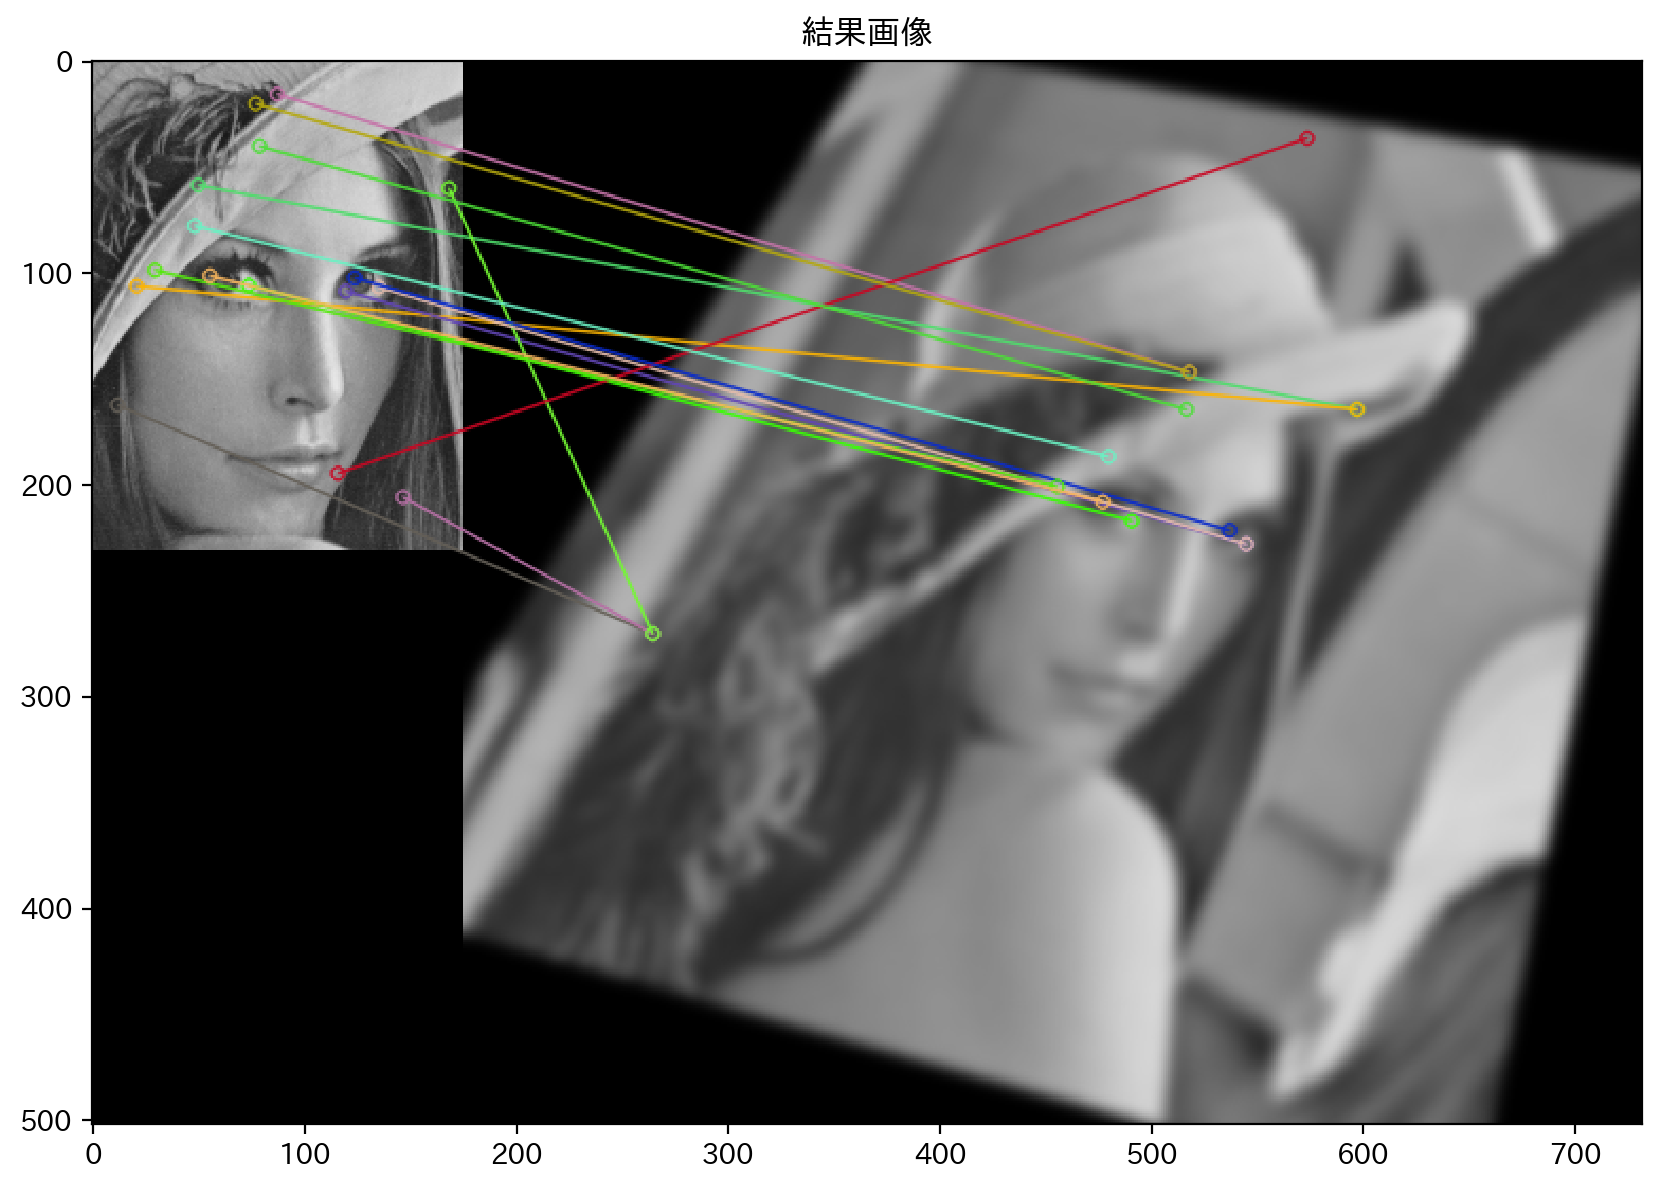

In [12]:
kp3, des3 = sift.detectAndCompute(img5, None)
dst_img=cv2.drawKeypoints(img5, kp3, des3)

matches = bf_matcher.knnMatch(des1, des3, k=2)
good = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

dst_img3 = cv2.drawMatches(img1,kp1,img5,kp3,good,None, flags=2)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('結果画像')
ax1.imshow(dst_img3, cmap='gray')
plt.show()

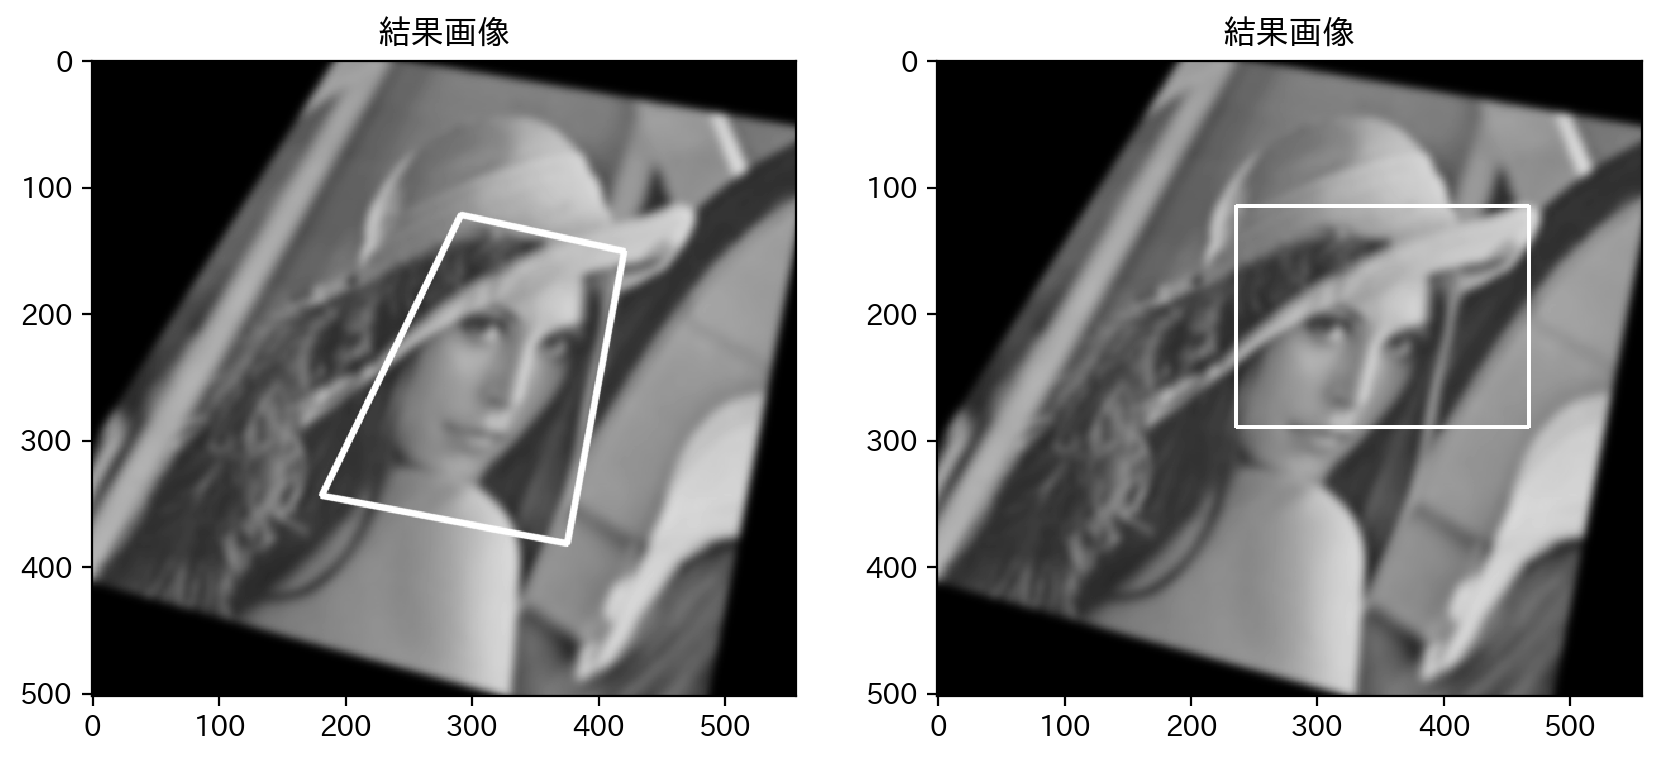

In [13]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp3[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

img6 = cv2.polylines(img5,[np.int32(dst)],True,255,3, cv2.LINE_AA)

fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('結果画像')
ax1.imshow(img6, cmap='gray')

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('結果画像')
ax2.imshow(src_img2, cmap='gray')
plt.show()

## 文字認識

In [14]:
from PIL import Image
import pytesseract

In [16]:
img = Image.open('./img/helloworld.png')
result = pytesseract.image_to_string(img)
print(result)

Hello, World !!
